In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
%matplotlib inline

import pandas as pd # data handling
import numpy as np # numerical computation packages in python
import cmath # for handling complex numbers
import matplotlib.pyplot as plt # plotting routines
from scipy.integrate import odeint # solving the system of differential equations
import scipy.optimize as opt
import sympy as sp # symbolic mathematics for finding fixed points

In [2]:
#PART 1- SOLVING NETWORK EQUATIONS

In [3]:
#1. Defining commonly used parameters

# Consumer/Generator vector. P_i = p if generator, P_i = -p if consumer 
p = 1 # value used in Nonlocal failures paper
P = np.asarray([-p, p, p, p, -p, -p, p, -p])

# damping constant
alpha = np.asarray([p]*8) # value used in Nonlocal failures paper- see fig 4

# Adjacency matrix. K[i,j] = k if link exists between nodes i and j, K[i,j] = 0 otherwise
# Link (0,1) is equivalent to link (1,2) in diagram

k = 1.03*p # value used in Nonlocal failures paper- see fig 4
dk = k # value used in Nonlocal failures paper- see fig 4
K = np.asarray([[0, k, 0, 0, 0, k, k, 0], 
                [k, 0, k, 0+dk, 0, 0, 0, 0], 
                [0, k, 0, k, 0, 0, k, 0],
                [0, 0+dk, k, 0, k, 0, 0, k],
                [0, 0, 0, k, 0, k, 0, 0],
                [k, 0, 0, 0, k, 0, 0, k],
                [k, 0, k, 0, 0, 0, 0, 0],
                [0, 0, 0, k, 0, k, 0, 0]])

# control vector
C = np.asarray([0]*8)

budget = .2
C_braess = np.asarray([budget/8]*8) #without control, lots of networks have a second zero eigenvalue

In [4]:
#2. System of equations describing the oscillator model
def oscillator_model(X, t, K, C, P, alpha):
    
    # i = node under consideration
    # j = coupled node
    
    # phi_0, ..., phi_7, omega_0, ..., omega_7  = X #unpacking state vector
    phi = np.asarray([X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7]])
    omega = np.asarray([X[8], X[9], X[10], X[11], X[12], X[13], X[14], X[15]])
    
    # preallocating vectors
    coupling = np.zeros((8,1))
    dphi = np.zeros((8,1))
    domega = np.zeros((8,1))
    
    # calculating coupling term of each omega equation
    for a in range(len(coupling)):
        for b in range(len(coupling)):
            coupling[a] = coupling[a] + K[a,b]*np.sin(phi[b]-phi[a])
      
    # system of equations to be solved
    dphi[0] = omega[0]
    dphi[1] = omega[1]
    dphi[2] = omega[2]
    dphi[3] = omega[3]
    dphi[4] = omega[4]
    dphi[5] = omega[5]
    dphi[6] = omega[6]
    dphi[7] = omega[7]
    domega[0] = - alpha[0]*omega[0] - C[0]*phi[0] + P[0] + coupling[0]
    domega[1] = - alpha[1]*omega[1] - C[1]*phi[1] + P[1] + coupling[1]
    domega[2] = - alpha[2]*omega[2] - C[2]*phi[2] + P[2] + coupling[2]
    domega[3] = - alpha[3]*omega[3] - C[3]*phi[3] + P[3] + coupling[3] 
    domega[4] = - alpha[4]*omega[4] - C[4]*phi[4] + P[4] + coupling[4]
    domega[5] = - alpha[5]*omega[5] - C[5]*phi[5] + P[5] + coupling[5]
    domega[6] = - alpha[6]*omega[6] - C[6]*phi[6] + P[6] + coupling[6]
    domega[7] = - alpha[7]*omega[7] - C[7]*phi[7] + P[7] + coupling[7]    
    
    # concatenating vectors into single solution vector
    dXdt = np.asarray([dphi, domega])
    dXdt = dXdt.reshape(16)
    
    return dXdt

In [40]:
#3. Use a package to solve the differential equation for 25 time units

#initial conditions x0=[phi_0, phi_1, ..., omega_0, omega_1, ...]
x0 = [.0]*16
t = np.linspace(0, 75, 100000) #time span

#solver
#sol_1 = odeint(oscillator_model, x0, t, args=(K,C,P,alpha)) #initial net without control
sol_1 = odeint(oscillator_model, fp, t, args=(K,C_braess,P,alpha)) #initial net with control
#sol_1 = odeint(oscillator_model, x0, t, args=(worst_net,C_braess,P,alpha)) #worst net with control

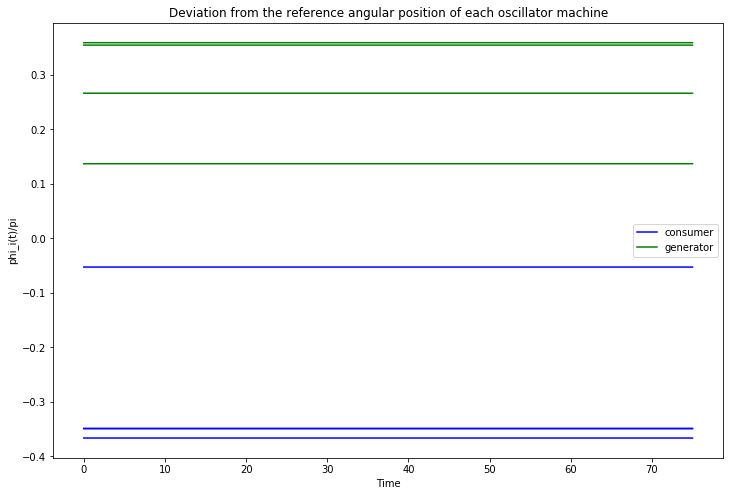

In [41]:
#4. Plotting time domain angular solutions of oscillator network
plt.figure(figsize=(12,8))
#plt.ylim((-.17,.17))
plt.plot(t, sol_1[:, 0]/np.pi, color='b', label='consumer')
plt.plot(t, sol_1[:, 1]/np.pi, color='g', label='generator')
plt.plot(t, sol_1[:, 2]/np.pi, color='g')
plt.plot(t, sol_1[:, 3]/np.pi, color='g')
plt.plot(t, sol_1[:, 4]/np.pi, color='b')
plt.plot(t, sol_1[:, 5]/np.pi, color='b')
plt.plot(t, sol_1[:, 6]/np.pi, color='g')
plt.plot(t, sol_1[:, 7]/np.pi, color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('BP_worst_phase.jpg')
#plt.show()

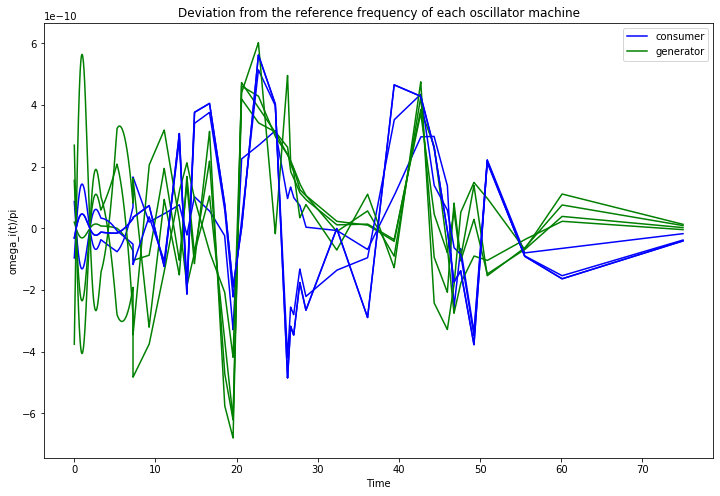

In [42]:
#5. Plotting time domain frequency solutions of oscillator network
plt.figure(figsize=(12,8))
#plt.ylim((-.15,.15))
plt.plot(t, sol_1[:, 8]/np.pi, color='b', label='consumer')
plt.plot(t, sol_1[:, 9]/np.pi, color='g', label='generator')
plt.plot(t, sol_1[:, 10]/np.pi, color='g')
plt.plot(t, sol_1[:, 11]/np.pi, color='g')
plt.plot(t, sol_1[:, 12]/np.pi, color='b')
plt.plot(t, sol_1[:, 13]/np.pi, color='b')
plt.plot(t, sol_1[:, 14]/np.pi, color='g')
plt.plot(t, sol_1[:, 15]/np.pi, color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('omega_i(t)/pi')
plt.title('Deviation from the reference frequency of each oscillator machine');
#plt.savefig('BP_worst_freq.jpg')
#plt.show()

In [35]:
#PART 2- STABILITY ANALYSIS AROUND FIXED POINT

In [36]:
#1. Integration method for finding fixed point
def fixed_point(final_ts, prev_ts, dt, tol):
    
    #compute time derivative
    deriv = (final_ts - prev_ts)/dt
    
    #check for steady-state solution
    norm_2 = np.linalg.norm(deriv)
    if (norm_2 < tol):
        ss = True
    else:
        ss = False
        
    return norm_2, ss, final_ts

In [37]:
tol = 10**-5 #tolerance for verifying derivative is zero
norm, ss, fp  = fixed_point(sol_1[len(sol_1)-1], sol_1[len(sol_1)-2], t[len(t)-1]-t[len(t)-2], tol)
print("Time derivative norm was:", norm, "\n")
print("Does a steady state exist?", ss, "\n")
print("The fixed point was: \n", fp)

Time derivative norm was: 6.89699990456494e-08 

Does a steady state exist? True 

The fixed point was: 
 [-1.65442576e-01  8.36508700e-01  1.12778200e+00  4.30202838e-01
 -1.09603488e+00 -1.15079868e+00  1.11381748e+00 -1.09603488e+00
 -3.00609220e-10  8.47845558e-10 -1.17973081e-09  6.39532438e-11
 -9.76703843e-11  2.73622914e-10  4.90259019e-10 -9.76703843e-11]


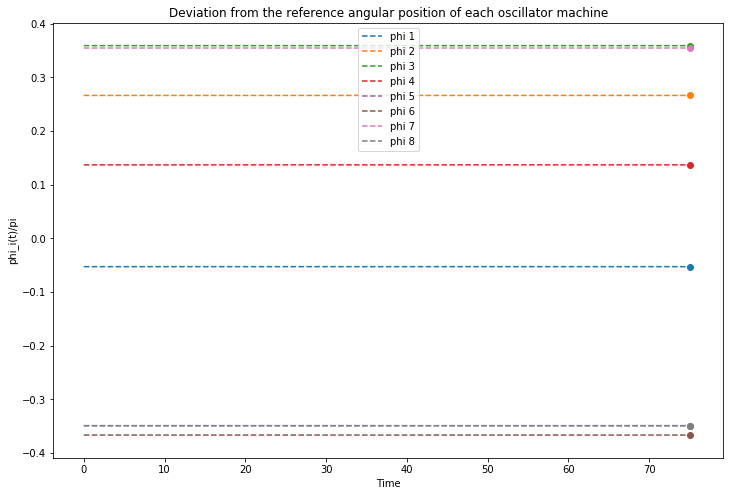

In [44]:
#3. Plotting fixed point against phase dynamics
plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 0]/np.pi, '--', label='phi 1')
plt.plot(t, sol_1[:, 1]/np.pi, '--', label='phi 2')
plt.plot(t, sol_1[:, 2]/np.pi, '--', label='phi 3')
plt.plot(t, sol_1[:, 3]/np.pi, '--', label='phi 4')
plt.plot(t, sol_1[:, 4]/np.pi, '--', label='phi 5')
plt.plot(t, sol_1[:, 5]/np.pi, '--', label='phi 6')
plt.plot(t, sol_1[:, 6]/np.pi, '--', label='phi 7')
plt.plot(t, sol_1[:, 7]/np.pi, '--', label='phi 8')

plt.scatter(t[len(t)-1], fp[0]/np.pi)
plt.scatter(t[len(t)-1], fp[1]/np.pi)
plt.scatter(t[len(t)-1], fp[2]/np.pi)
plt.scatter(t[len(t)-1], fp[3]/np.pi)
plt.scatter(t[len(t)-1], fp[4]/np.pi)
plt.scatter(t[len(t)-1], fp[5]/np.pi)
plt.scatter(t[len(t)-1], fp[6]/np.pi)
plt.scatter(t[len(t)-1], fp[7]/np.pi)

plt.legend(loc='upper center')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('fp_dem3.jpg')
#plt.show()

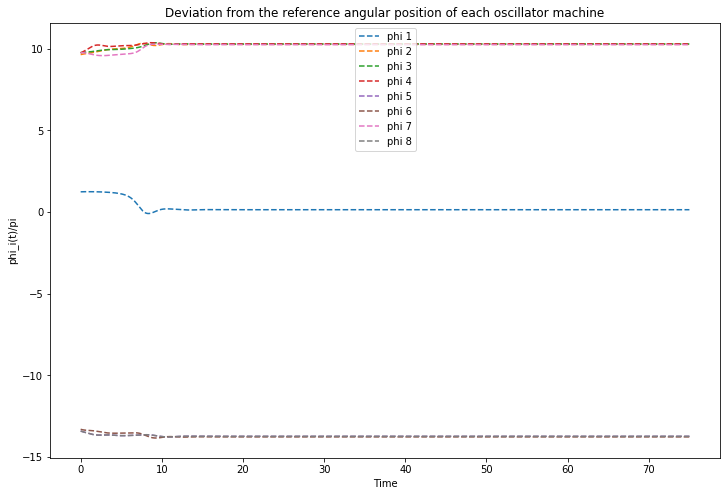

In [12]:
#4. Verifying fixed points
sol_2 = odeint(oscillator_model, fp, t, args=(K,C_braess,P,alpha)) #initial net with control
plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 0]/np.pi, '--', label='phi 1')
plt.plot(t, sol_1[:, 1]/np.pi, '--', label='phi 2')
plt.plot(t, sol_1[:, 2]/np.pi, '--', label='phi 3')
plt.plot(t, sol_1[:, 3]/np.pi, '--', label='phi 4')
plt.plot(t, sol_1[:, 4]/np.pi, '--', label='phi 5')
plt.plot(t, sol_1[:, 5]/np.pi, '--', label='phi 6')
plt.plot(t, sol_1[:, 6]/np.pi, '--', label='phi 7')
plt.plot(t, sol_1[:, 7]/np.pi, '--', label='phi 8')

plt.legend(loc='upper center')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('good_fp_dynamics.jpg')
#plt.show()

In [13]:
#5. Finds eigenvalues of the Laplacian and Jacobian. Returns ordered arrays with imaginary component removed
def find_eigs(K, C, alpha, fp):

    # i = node under consideration
    # j = coupled node
    
    # preallocating vectors
    L = np.zeros((8,8)) # Laplacian
    
    # calculating each Laplacian term
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):            
            if i!=j:
                L[i,j] = -K[i,j]*np.cos(fp[i] - fp[j])
            else:
                for l in range(L.shape[1]):
                    if l==i:
                        continue # excludes L[i,i]
                    L[i,j] = L[i,j] + K[i,l]*np.cos(fp[i] - fp[l])
    
    # converting system of equations into matrix form
    zero = np.zeros((8,8))
    one = np.eye(8)
    A = alpha*np.eye(8) # damping parameter is same for all nodes
    C = C*np.eye(8) # control matrix
    
    # joining matrices into one large system
    J1 = np.concatenate((zero, -L-C))
    J2 = np.concatenate((one, -A))
    J = np.concatenate((J1, J2), axis=1)
    
    # computing eigenvalues
    eig_L = np.linalg.eig(L)
    eig_J = np.linalg.eig(J)
    
    # extracting eigenvalues
    eig_L = eig_L[0]
    eig_J = eig_J[0]
    
    # converting to numpy arrays
    eig_L = np.asarray(eig_L)
    eig_J = np.asarray(eig_J)
    
    # removing imaginary component
    eig_J = eig_J.real
    
    # sorting eigenvalues into ascending order
    # the linked Jacobian eigenvalues without imaginary components will be at opposite ends of the array 
    eig_L.sort()
    eig_J.sort()
    
    # splitting array into two and reordering the second part of the array such that the same index maps to the same
    # Laplacian eigenvalue
    eig_J1 = eig_J[0:L.shape[0]]
    eig_J2 = eig_J[L.shape[0+1]:len(eig_J)]
    eig_J2 = sorted(eig_J2,reverse=True)
    
    # combining into one nx2 matrix
    eig_J = np.asarray([eig_J1, eig_J2])
    
    return eig_L, eig_J

In [14]:
#6. Storing eigenvalues of laplacian and jacobian
#eig_L_comp, eig_J_comp = find_eigs(K, C, alpha, fp) #initial net without control
eig_L_comp, eig_J_comp = find_eigs(K, C_braess, alpha, fp) #initial net with control
#eig_L_comp, eig_J_comp = find_eigs(worst_net, C_braess, alpha, fp) #worst net with control

print("Eigenvalues of Laplacian:\n", eig_L_comp, "\n")
print("Eigenvalues of Jacobian:\n", eig_J_comp, "\n")

Eigenvalues of Laplacian:
 [3.80357621e-16 2.37175008e-01 1.07433604e+00 1.24339083e+00
 1.40303599e+00 3.10295930e+00 3.59482514e+00 3.98574242e+00] 

Eigenvalues of Jacobian:
 [[-0.97434165 -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.02565835 -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]] 



In [15]:
# for comparing eigenvalue distributions
#eig_L_comp_worst, eig_J_comp_worst = find_eigs(worst_net, C_braess, alpha, fp) #worst net with control
#print("Eigenvalues of Laplacian:\n", eig_L_comp_worst, "\n")
#print("Eigenvalues of Jacobian:\n", eig_J_comp_worst, "\n")

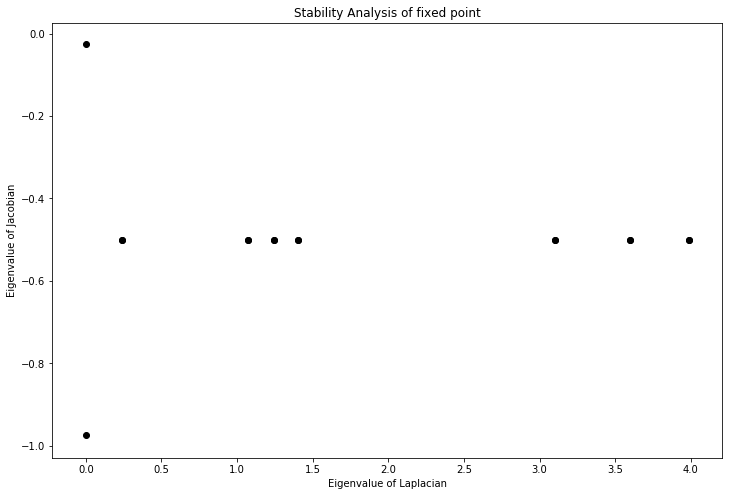

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(eig_L_comp, eig_J_comp[0], color='k')
plt.scatter(eig_L_comp, eig_J_comp[1], color='k')
#plt.scatter(eig_L_comp_worst, eig_J_comp_worst[0], color='r', label="Most Unstable Network")
#plt.scatter(eig_L_comp_worst, eig_J_comp_worst[1], color='r')
#plt.legend(loc='best')
plt.xlabel('Eigenvalue of Laplacian')
plt.ylabel('Eigenvalue of Jacobian')
plt.title('Stability Analysis of fixed point');
#plt.savefig('BP_eigs.jpg')
#plt.show()

In [377]:
#PART 3- OPTIMIZATION

In [378]:
#1. Defining objective function- second largest jacobian eigenvalue. Largest will be constant since it corresponds to the
#zero laplacian eigenvalue
def max_eig(K, C, alpha, fp):

    # i = node under consideration
    # j = coupled node
    
    # preallocating vectors
    L = np.zeros((8,8)) # Laplacian
    
    # calculating each Laplacian term
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):            
            if i!=j:
                L[i,j] = -K[i,j]*np.cos(fp[i] - fp[j])
            else:
                for l in range(L.shape[1]):
                    if l==i:
                        continue # excludes L[i,i]
                    L[i,j] = L[i,j] + K[i,l]*np.cos(fp[i] - fp[l])
    
    # converting system of equations into matrix form
    zero = np.zeros((8,8))
    one = np.eye(8)
    A = alpha*np.eye(8) # damping parameter is same for all nodes
    C = C*np.eye(8) # control matrix
    
    # joining matrices into one large system
    J1 = np.concatenate((zero, -L-C))
    J2 = np.concatenate((one, -A))
    J = np.concatenate((J1, J2), axis=1)
    
    # computing eigenvalues
    eig_J = np.linalg.eig(J)
    
    # extracting eigenvalues
    eig_J = eig_J[0]
    
    # converting to numpy arrays
    eig_J = np.asarray(eig_J)
    
    # removing imaginary component
    eig_J = eig_J.real
    
    # sorting eigenvalues into ascending order
    # the linked Jacobian eigenvalues without imaginary components will be at opposite ends of the array 
    eig_J.sort()
    
    return eig_J[len(eig_J)-2] # second largest Jacobian eig-val

In [379]:
# Systematic optimization

In [380]:
#2. Systematically adding edges to original net and finding what is the most unstable
def braess_paradox(K, k, C_braess, alpha, P, x0, t, tol):
    
    #compute fixed point of initial network
    sol = odeint(oscillator_model, x0, t, args=(K,C_braess,P,alpha))
    norm2, steady_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], tol)
    
    #compute eigenvalue of original network
    if (steady_s):
        orig_worst_eig = max_eig(K, C_braess, alpha, f_p)
    else:
        orig_worst_eig = -np.inf #indicates fixed point didnt exist
        
    #update variables for tracking the most unstable network
    worst_eig = orig_worst_eig
    worst_net = K
    worst_added_edges = None
    worst_fp = f_p
    
    for i in range(len(K)):
        for j in range(len(K)):
                    
            #add new edges to K (symmetric matrix)
            K[i,j] += k
            K[j,i] += k

            #only evaluate networks without self-edges
            if (np.trace(K) != 0):
                K[i,j] -= k
                K[j,i] -= k
                continue

            #only evaluate simple networks (max 1 edge between each node)
            if (np.amax(K) > k):
                K[i,j] -= k
                K[j,i] -= k
                continue
            
            #compute fixed point of network
            sol = odeint(oscillator_model, x0, t, args=(K,C_braess,P,alpha))
            norm2, steady_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], tol)

            #compute network's eigenvalues if fixed point exists
            if (steady_s):    
                eig = max_eig(K, C_braess, alpha, f_p)
            else:
                #remove new edges from K
                K[i,j] -= k
                K[j,i] -= k
                continue

            #store the network and eigenvalue of the most unstable network
            if (eig > worst_eig):
                worst_eig = eig
                worst_net = np.zeros(K.shape) + K
                worst_added_edges = np.asarray([i,j]) + np.ones(len([i,j])) #changing indices to go from 1 to 8
                worst_fp = f_p

            #remove new edges from K
            K[i,j] -= k
            K[j,i] -= k
        
    return orig_worst_eig, worst_eig, worst_net, worst_added_edges, worst_fp

In [381]:
results = braess_paradox(K, k, C_braess, alpha, P, x0, t, tol)
orig_worst_eig, worst_eig, worst_net, worst_added_edges, worst_fp = results

print("original second eigenvalue =", orig_worst_eig, "\n")
print("   worst second eigenvalue =", worst_eig, "\n")
print("worst network:\n", worst_net, "\n")
print("edges added to original network = ", worst_added_edges, "\n")
print("worst fixed point:\n ", worst_fp, "\n")

original second eigenvalue = -0.49999999999999906 

   worst second eigenvalue = -0.3740226141591304 

worst network:
 [[0.   1.03 0.   0.   0.   1.03 1.03 0.  ]
 [1.03 0.   1.03 1.03 0.   0.   1.03 0.  ]
 [0.   1.03 0.   1.03 0.   0.   1.03 0.  ]
 [0.   1.03 1.03 0.   1.03 0.   0.   1.03]
 [0.   0.   0.   1.03 0.   1.03 0.   0.  ]
 [1.03 0.   0.   0.   1.03 0.   0.   1.03]
 [1.03 1.03 1.03 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.03 0.   1.03 0.   0.  ]] 

edges added to original network =  [2. 7.] 

worst fixed point:
  [-1.64751777e-01  8.96202219e-01  1.12259225e+00  4.58700028e-01
 -1.09223528e+00 -1.14770327e+00  1.01943112e+00 -1.09223528e+00
  1.42571248e-09  1.25409891e-09  1.25516337e-09  5.99802659e-10
  1.27385564e-09  1.31911140e-09  4.59385364e-10  1.27385564e-09] 



In [ ]:
# Attempting to add one edge to Network a with a uniformly distributed control budget of 0.2, the
# results were as follows:

# original second eigenvalue = -0.499999999999999 

#    worst second eigenvalue = -0.2792482494297409 

# worst network:
# [[0.   1.03 0.   0.   0.   1.03 1.03 0.  ]
# [1.03 0.   1.03 0.   0.   0.   0.   0.  ]
# [0.   1.03 0.   1.03 0.   0.   1.03 0.  ]
# [0.   0.   1.03 0.   1.03 1.03 0.   1.03]
# [0.   0.   0.   1.03 0.   1.03 0.   0.  ]
# [1.03 0.   0.   1.03 1.03 0.   0.   1.03]
# [1.03 0.   1.03 0.   0.   0.   0.   0.  ]
# [0.   0.   0.   1.03 0.   1.03 0.   0.  ]] 

# edges added to original network =  [4. 6.] 

# worst fixed point:
#  [ 6.75014252e-02  1.21655661e+00  1.18758442e+00 -3.77767451e-01
# -1.17883755e+00 -9.52756534e-01  1.21655661e+00 -1.17883755e+00
# -9.84180150e-10 -1.30594277e-09 -1.36743441e-09  7.51191309e-10
#  6.85385375e-10 -4.08966891e-11 -1.30594277e-09  6.85385375e-10] 

In [388]:
# Attempting to add one edge to Network c with a uniformly distributed control budget of 0.2, the
# results were as follows:

#original second eigenvalue = -0.49999999999999906 

#   worst second eigenvalue = -0.3740226141591304 

#worst network:
# [[0.   1.03 0.   0.   0.   1.03 1.03 0.  ]
# [1.03 0.   1.03 1.03 0.   0.   1.03 0.  ]
# [0.   1.03 0.   1.03 0.   0.   1.03 0.  ]
# [0.   1.03 1.03 0.   1.03 0.   0.   1.03]
# [0.   0.   0.   1.03 0.   1.03 0.   0.  ]
# [1.03 0.   0.   0.   1.03 0.   0.   1.03]
# [1.03 1.03 1.03 0.   0.   0.   0.   0.  ]
# [0.   0.   0.   1.03 0.   1.03 0.   0.  ]] 

#edges added to original network =  [2. 7.] 

#worst fixed point:
#  [-1.64751777e-01  8.96202219e-01  1.12259225e+00  4.58700028e-01
# -1.09223528e+00 -1.14770327e+00  1.01943112e+00 -1.09223528e+00
#  1.42571248e-09  1.25409891e-09  1.25516337e-09  5.99802659e-10
#  1.27385564e-09  1.31911140e-09  4.59385364e-10  1.27385564e-09] 